<a href="https://colab.research.google.com/github/mayalenE/sketch-transformer/blob/main/mixture_density_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mixture Density Network (MDN)

## Imports and Utils

In [ ]:
!pip install -q ipympl

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib import cm
from google.colab import output

In [ ]:
torch.manual_seed(2024)
output.enable_custom_widget_manager()
%matplotlib widget

## One-to-Many function

In [ ]:
n_samples = 100

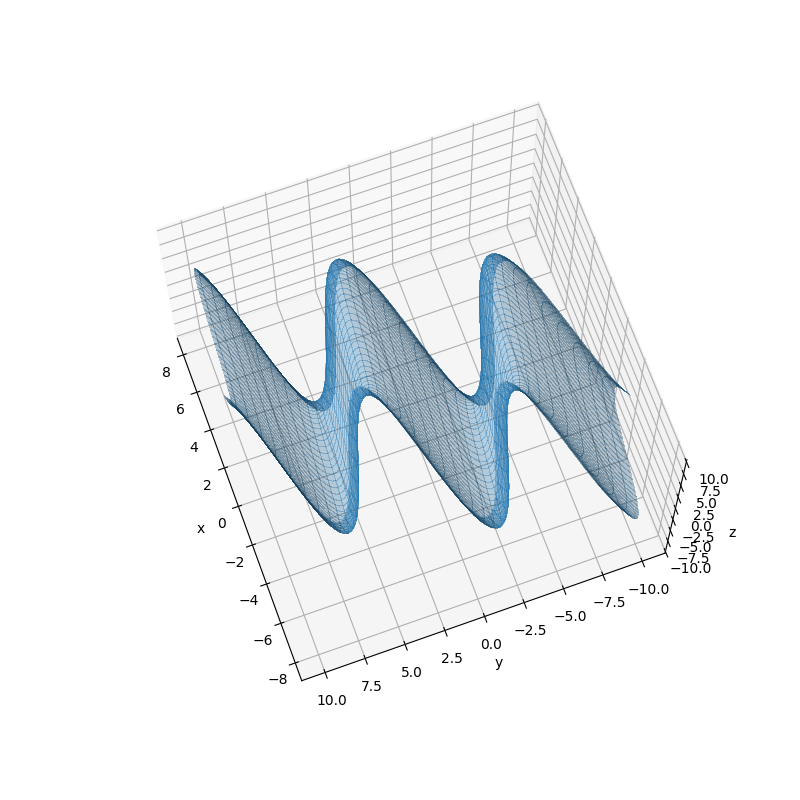

In [ ]:
epsilon = torch.randn(n_samples)
y_data = torch.linspace(-10, 10, n_samples)
z_data = torch.linspace(-10, 10, n_samples)
yy, zz = torch.meshgrid(y_data, z_data)
xx = (7*torch.sin(0.75*yy) + 0.5*yy + 3*torch.sin(0.35*zz) + 0.2*zz)/2 #+ epsilon
X, Y, Z = xx.reshape(-1, 1), yy.reshape(-1, 1), zz.reshape(-1, 1)


fig, ax = plt.subplots(figsize=(8,8), subplot_kw={"projection": "3d"})
ax.plot_surface(xx, yy, zz, linewidth=0, antialiased=False, alpha=0.3)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.view_init(elev=70., azim=160)
plt.show()

## Regression (MLP + MSE)

In [ ]:
class MLP(nn.Module):

    def __init__(self, n_input, n_hidden, n_output):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(n_input, n_hidden), nn.Tanh(),
                                 nn.Linear(n_hidden, n_output))

    def forward(self, x):
        return self.net(x)

In [ ]:
mlp = MLP(1, 100, 2)
sum([p.nelement() for p in mlp.parameters()])

402

In [ ]:
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.1)

losses = []
for optim_step in range(200):

    # forward
    YZ_pred = mlp(X)
    YZ = torch.concatenate([Y, Z], dim=1)
    loss = ((YZ-YZ_pred)**2).sum()
    losses.append(loss.item())

    # backward
    optimizer.zero_grad()
    loss.backward()

    # update
    optimizer.step()

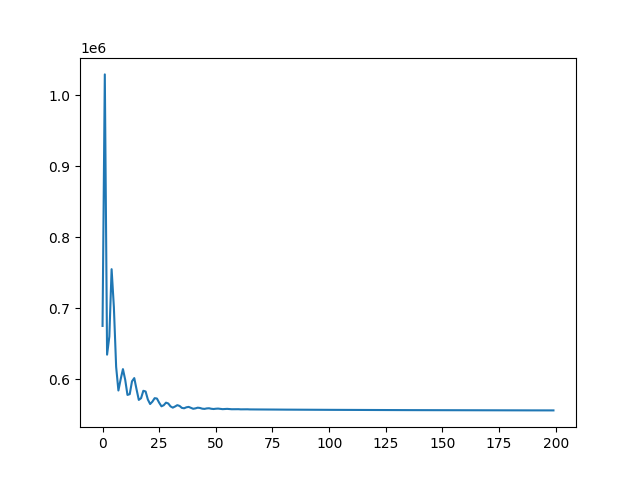

In [ ]:
plt.figure()
plt.plot(losses)
plt.show()

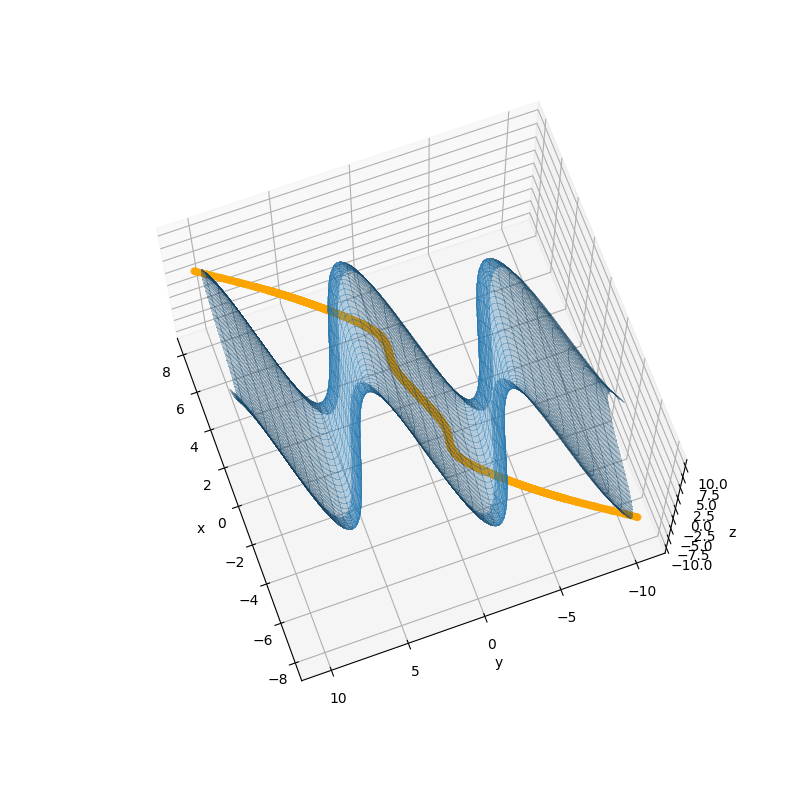

In [ ]:
yy_pred = YZ_pred[:, 0].detach().reshape(n_samples, n_samples)
zz_pred = YZ_pred[:, 1].detach().reshape(n_samples, n_samples)

fig, ax = plt.subplots(figsize=(8,8), subplot_kw={"projection": "3d"})
ax.plot_surface(xx, yy, zz, linewidth=0, antialiased=False, alpha=0.3)
ax.scatter(xx, yy_pred, zz_pred, color="orange", alpha=0.3)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.view_init(elev=70., azim=160)
plt.show()

## Mixture Density Network (MDN)

Multivariate Normal Distribution pdf:

* General Case:
$$ f_{\mathbf {X} }(x_{1},\ldots ,x_{k})={\frac {\exp \left(-{\frac {1}{2}}\left({\mathbf {x} }-{\boldsymbol {\mu }}\right)^{\mathrm {T} }{\boldsymbol {\Sigma }}^{-1}\left({\mathbf {x} }-{\boldsymbol {\mu }}\right)\right)}{\sqrt {(2\pi )^{k}|{\boldsymbol {\Sigma }}|}}}$$

* 2D case:
$$ f(x,y)={\frac {1}{2\pi \sigma _{X}\sigma _{Y}{\sqrt {1-\rho ^{2}}}}}\exp \left(-{\frac {1}{2\left[1-\rho ^{2}\right]}}\left[\left({\frac {x-\mu _{X}}{\sigma _{X}}}\right)^{2}-2\rho \left({\frac {x-\mu _{X}}{\sigma _{X}}}\right)\left({\frac {y-\mu _{Y}}{\sigma _{Y}}}\right)+\left({\frac {y-\mu _{Y}}{\sigma _{Y}}}\right)^{2}\right]\right) $$
where $$ {\boldsymbol {\mu}} ={\begin{pmatrix}\mu _{X} \\ \mu _{Y}\end{pmatrix}},\quad {\boldsymbol {\Sigma }}={\begin{pmatrix}\sigma _{X}^{2}&\rho \sigma _{X}\sigma _{Y} \\ \rho \sigma _{X}\sigma _{Y}&\sigma _{Y}^{2}\end{pmatrix}}, \rho \in [-1,1], \sigma_x > 0, \sigma_y > 0 $$


In [ ]:
import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal, OneHotCategorical

class MDN(nn.Module):
    """
    Mixture density network compatible with full covariance.
    Taken and slightly adapted from https://github.com/haimengzhao/full-cov-mdn

    [ Bishop, 1994 ]

    Parameters
    ----------
    dim_in: int; dimensionality of the covariates
    dim_out: int; dimensionality of the response variable
    dim_hidden: int; dimensionality of the hidden layer
    n_components: int; number of components in the mixture model
    full_cov: bool; whether to use full or diagonal covariance matrix
    """
    def __init__(self, dim_in, dim_hidden, dim_out, n_components, full_cov=True):
        super().__init__()
        self.hidden_net = nn.Sequential(nn.Linear(dim_in, dim_hidden), nn.Tanh())
        self.pi_net = CategoricalNetwork(dim_hidden, n_components)
        self.normal_net = NormalNetwork(dim_hidden, dim_out, n_components, full_cov)

    def forward(self, x, tau=1.):
        h = self.hidden_net(x)
        return self.pi_net(h, tau), self.normal_net(h, tau)

    def loss(self, x, y):
        pi, normal = self.forward(x)
        loglik = normal.log_prob(y.unsqueeze(1).expand_as(normal.loc))
        loss = -torch.logsumexp(torch.log(pi.probs) + loglik, dim=1)
        return loss

    def sample(self, x, tau=1.):
        pi, normal = self.forward(x, tau)
        samples = torch.sum(pi.sample().unsqueeze(2) * normal.sample(), dim=1)
        return samples

class NormalNetwork(nn.Module):
    def __init__(self, in_dim, out_dim, n_components, full_cov=True):
        super().__init__()
        self.n_components = n_components
        self.out_dim = out_dim
        self.full_cov = full_cov
        self.tril_indices = torch.tril_indices(row=out_dim, col=out_dim, offset=0)
        self.mean_net = nn.Linear(in_dim, out_dim * n_components)
        if full_cov:
            # Cholesky decomposition of the covariance matrix
            self.tril_net = nn.Linear(in_dim, int(out_dim * (out_dim + 1) / 2 * n_components))
        else:
            self.tril_net = nn.Linear(in_dim, out_dim * n_components)

    def forward(self, x, tau=1.):
        mean = self.mean_net(x).reshape(-1, self.n_components, self.out_dim)
        if self.full_cov:
            tril_values = self.tril_net(x).reshape(mean.shape[0], self.n_components, -1)
            tril = torch.zeros(mean.shape[0], mean.shape[1], mean.shape[2], mean.shape[2]).to(x.device)
            tril[:, :, self.tril_indices[0], self.tril_indices[1]] = tril_values
            # use diag = exp(diag) to ensure stric positivity of diagonal elements
            tril.diagonal(dim1=-2, dim2=-1)[:] = tril.diagonal(dim1=-2, dim2=-1).exp()
        else:
            tril = self.tril_net(x).reshape(mean.shape[0], self.n_components, -1)
            tril = torch.diag_embed(tril.exp())
        tril *= tau
        return MultivariateNormal(mean, scale_tril=tril)

class CategoricalNetwork(nn.Module):

    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.network = nn.Linear(in_dim, out_dim)

    def forward(self, x, tau=1.):
        logits = self.network(x) / tau
        return OneHotCategorical(logits=logits)

In [ ]:
mdn = MDN(1, 20, 2, 5)
sum([p.nelement() for p in mdn.parameters()])

670

In [ ]:
## Train
optimizer = torch.optim.Adam(mdn.parameters(), lr=1e-2)

losses = []
for optim_step in range(5000):

    # forward
    YZ = torch.concatenate([Y, Z], dim=1)
    loss = mdn.loss(X, YZ).mean()
    losses.append(loss.item())

    # backward
    optimizer.zero_grad()
    loss.backward()

    # update
    optimizer.step()

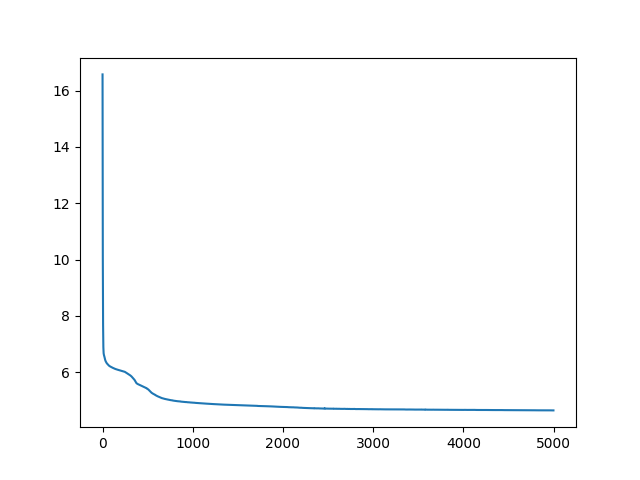

In [ ]:
plt.figure()
plt.plot(losses)
plt.show()

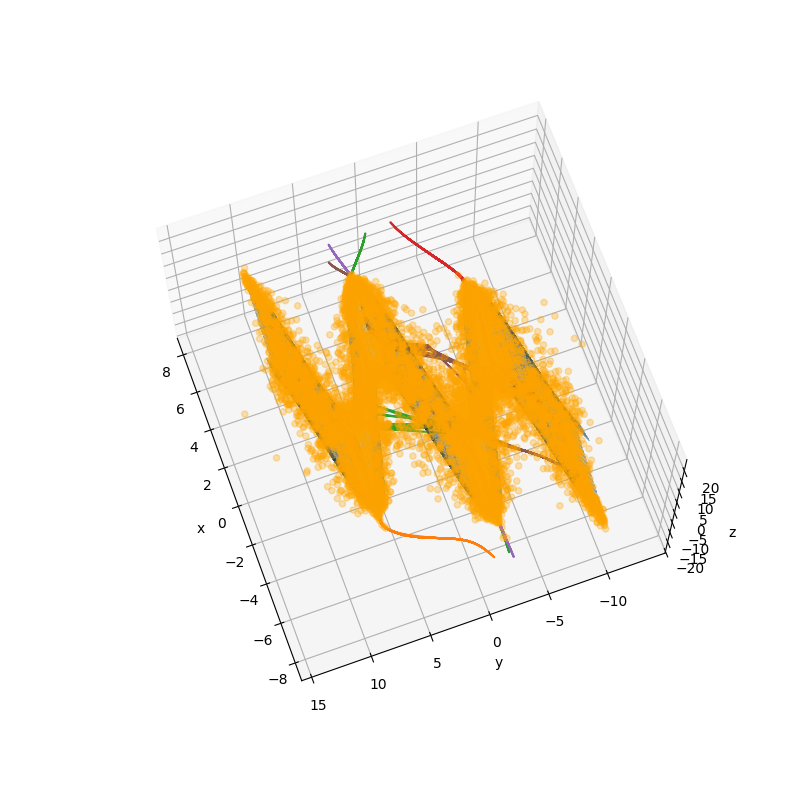

torch.Size([10, 2])

In [ ]:
## Sample
torch.manual_seed(1337)
tau=1.
pi, normal = mdn(X, tau=tau)
YZ_pred = mdn.sample(X, tau=tau) # try different temperatures
yy_pred = YZ_pred[:, 0].detach().reshape(n_samples, n_samples)
zz_pred = YZ_pred[:, 1].detach().reshape(n_samples, n_samples)

fig, ax = plt.subplots(figsize=(8,8), subplot_kw={"projection": "3d"})
ax.plot_surface(xx, yy, zz, linewidth=0, antialiased=False, alpha=0.3)
ax.scatter(xx, yy_pred, zz_pred, alpha=0.3, color="orange")
for i in range(5):
    ax.plot(X.squeeze(), normal.loc[:,i, 0].detach().squeeze(), normal.loc[:,i,1].detach().squeeze())
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.view_init(elev=70., azim=160)
plt.show()

mdn.sample(X[:10]).shape

## Next Steps

* Try different options for activation functions, normalization, etc.
* Replace softmax sampling of the GMM component with Gumbel Softmax which provides a sharper probability distribution, and could be useful to have sparser $\pi$-vector and remove not-needed components.